<a href="https://colab.research.google.com/github/Suwandi-amin-sangaji/colab-sqlinjection-detection/blob/main/LSTM_DETEKSI_SQL_INJECTION_DAN_XSS_ipy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# -*- coding: utf-8 -*-

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import nltk
import joblib
import re
from tensorflow.keras import models, layers
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import save_model
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from tensorflow.keras import regularizers
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Load dataset
path = '/content/drive/MyDrive/dataset/dataset_deteksi_xss_sql_injection/'
df = pd.read_csv(path + "sqli.csv", encoding='utf-16')
print("Data Shape:", df.shape)
df.head(10)

Data Shape: (4200, 2)


,Sentence,Label
0,a,1
1,a',1
2,a' --,1
3,a' or 1 = 1; --,1
4,@,1
5,?,1
6,' and 1 = 0 ) union all,1
7,? or 1 = 1 --,1
8,x' and userid is NULL; --,1
9,x' and email is NULL; --,1


In [ ]:
#tamplkan data null

print(df.isnull().sum())


Sentence    13
Label        0
dtype: int64


In [ ]:
df = df.dropna(subset=['Sentence'])

In [ ]:
print(df.isnull().sum())

Sentence    0
Label       0
dtype: int64


#PRE PROCESSING

In [ ]:
X = df['Sentence']
y = df['Label']
print(X.shape, y.shape)
print("Dataset Input:", "\n", X.head(5))
print("Dataset Label:", "\n", y.head(5))

(4187,) (4187,)
Dataset Input: 
 0                  a
1                a' 
2              a' --
3    a' or 1 = 1; --
4                  @
Name: Sentence, dtype: object
Dataset Label: 
 0    1
1    1
2    1
3    1
4    1
Name: Label, dtype: int64


In [ ]:
# Preprocessing
nltk.download('stopwords')
def preprocess_text(text):
    if not isinstance(text, str):  # Pastikan text adalah string
        text = ""

    text = text.lower()
    text = ''.join([char for char in text if char.isalnum() or char.isspace()])
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')])
    return text


df['Processed_Sentence'] = df['Sentence'].apply(preprocess_text)
X = df['Processed_Sentence']
y = df['Label']

vectorizer = TfidfVectorizer(min_df=2, max_df=0.8)
X = vectorizer.fit_transform(X.values.astype('U')).toarray()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


#PEMBAGIAN DATA 20:80

In [ ]:
# Split dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train1 = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test1 = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

#Model LSTM

In [ ]:
model = models.Sequential()
model.add(layers.LSTM(128, dropout=0.3, recurrent_dropout=0.3, kernel_regularizer=regularizers.l2(0.01),
                     input_shape=(X_train1.shape[1], X_train1.shape[2])))
model.add(layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(layers.Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 128)                 │       2,470,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,478,721 (9.46 MB)

 Trainable params: 2,478,721 (9.46 MB)

 Non-trainable params: 0 (0.00 B)

#TRANING DATA

In [ ]:
# Train model
history = model.fit(X_train1, y_train, epochs=50, validation_data=(X_test1, y_test))

Epoch 1/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 10s 19ms/step - accuracy: 0.7274 - loss: 3.7680 - val_accuracy: 0.6969 - val_loss: 0.6988
Epoch 2/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7549 - loss: 0.6181 - val_accuracy: 0.8067 - val_loss: 0.5716
Epoch 3/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - accuracy: 0.8251 - loss: 0.5274 - val_accuracy: 0.8174 - val_loss: 0.5317
Epoch 4/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - accuracy: 0.8358 - loss: 0.5096 - val_accuracy: 0.8186 - val_loss: 0.5073
Epoch 5/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8375 - loss: 0.4977 - val_accuracy: 0.8425 - val_loss: 0.4874
Epoch 6/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.8628 - loss: 0.4659 - val_accuracy: 0.8484 - val_loss: 0.4597
Epoch 7/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8731 - loss: 0.4426 - val_accuracy: 0.8532 - val_loss: 0.4458
Epoch 8/50
105/105 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.8833 - loss: 0.4256 - val_acc

In [ ]:
print("Distribusi Label:", y.value_counts())

Distribusi Label: Label
0    3060
1    1127
Name: count, dtype: int64


In [ ]:
# Evaluation
y_pred = (model.predict(X_test1).flatten() > 0.6).astype(int)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step
Accuracy: 0.9368
Precision: 1.0000
Recall: 0.7913
F1 Score: 0.8835


In [ ]:
# Store metrics in dictionaries
f1_dict = {"LSTM": f1}
precision_dict = {"LSTM": precision}
recall_dict = {"LSTM": recall}
accuracy_dict = {"LSTM": accuracy}

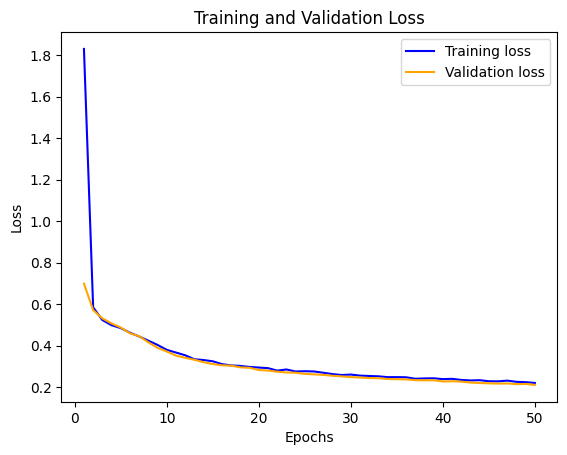

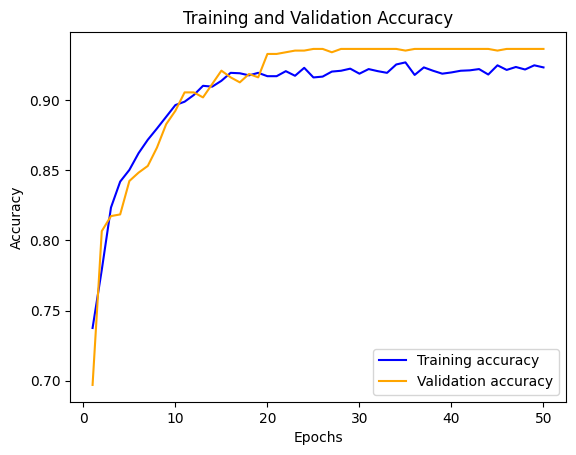

In [ ]:
# Plot model architecture
plot_model(model, show_shapes=True, to_file='LSTM.png')

# Plot training and validation loss
def plot_history(history):
    history_dict = history.history
    train_loss = history_dict['loss']
    val_loss = history_dict['val_loss']
    epochs = range(1, len(train_loss) + 1)
    plt.plot(epochs, train_loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'orange', label='Validation loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)

# Plot training and validation accuracy
def plot_historyAcc(history):
    history_dict = history.history
    train_acc = history_dict['accuracy']
    val_acc = history_dict['val_accuracy']
    epochs = range(1, len(train_acc) + 1)
    plt.plot(epochs, train_acc, 'b', label='Training accuracy')
    plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_historyAcc(history)

# Plot confusion matrix
def plot_confusion_matrix(conf_matrix):
    fig, ax = plt.subplots(figsize=(7.5, 7.5))
    ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
    for i in range(conf_matrix.shape[0]):
        for j in range(conf_matrix.shape[1]):
            ax.text(x=j, y=i, s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
    plt.xlabel('Predicted Value', fontsize=18)
    plt.ylabel('Actual Value', fontsize=18)
    plt.title('Confusion Matrix', fontsize=18)
    plt.show()

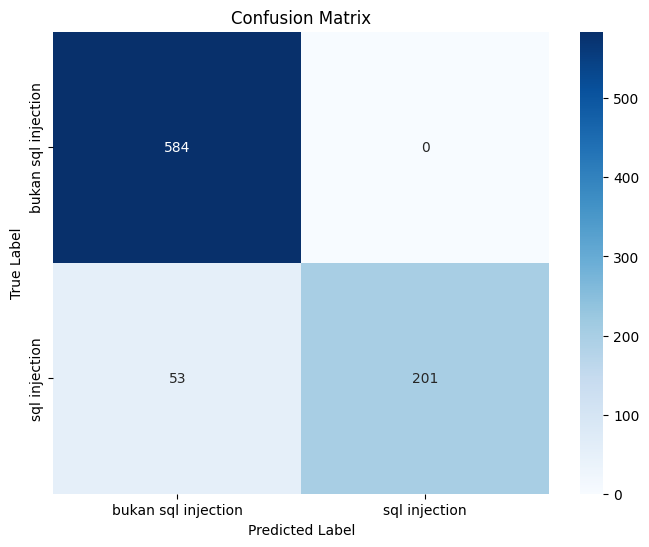

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Hitung confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Buat heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["bukan sql injection", "sql injection"],
            yticklabels=["bukan sql injection", "sql injection"])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
from sklearn.metrics import classification_report

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=["bukan sql injection", "sql injection"]))

Classification Report:
                     precision    recall  f1-score   support

bukan sql injection       0.92      1.00      0.96       584
      sql injection       1.00      0.79      0.88       254

           accuracy                           0.94       838
          macro avg       0.96      0.90      0.92       838
       weighted avg       0.94      0.94      0.93       838



In [ ]:
import pandas as pd

# Simpan classification report ke file CSV
report = classification_report(y_test, y_pred, target_names=["bukan sql injection", "sql injection"], output_dict=True)
report_df = pd.DataFrame(report).transpose()
report_df.to_csv('classification_report.csv')

# Simpan confusion matrix ke file CSV
cm_df = pd.DataFrame(cm, index=["bukan sql injection", "sql injection"], columns=["bukan sql injection", "sql injection"])
cm_df.to_csv('confusion_matrix.csv')

In [ ]:
import joblib
from tensorflow.keras.models import save_model

# Save model & vectorizer
save_model(model, 'sql_injection_lstm_model.h5')
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score

# Data baru
new_data = ["admin' OR '1'='1",
            "SELECT * FROM users",
            "This is a normal query",
            "DROP TABLE users",
            "Hello, world!",
            "hai",
            "'||'6"]

# Label sebenarnya (1 = SQL Injection, 0 = Bukan SQL Injection)
y_new_true = [1, 1, 0, 1, 0, 0, 1]

# Preprocessing data baru
new_data_processed = [preprocess_text(sentence) for sentence in new_data]
X_new = vectorizer.transform(new_data_processed).toarray()
X_new_reshaped = X_new.reshape(X_new.shape[0], 1, X_new.shape[1])

# Prediksi probabilitas
y_new_proba = model.predict(X_new_reshaped).flatten()

# Prediksi label (dengan threshold 0.6)
y_new_pred = (y_new_proba > 0.6).astype(int)

# Tampilkan hasil prediksi, probabilitas, dan label sebenarnya
for i, sentence in enumerate(new_data):
    print(f"Kalimat: {sentence}")
    print(f"Label Sebenarnya: {'SQL Injection' if y_new_true[i] == 1 else 'Bukan SQL Injection'}")
    print(f"Label Prediksi: {'SQL Injection' if y_new_pred[i] == 1 else 'Bukan SQL Injection'}")
    print(f"Probabilitas: {y_new_proba[i]:.4f}")
    print("-" * 50)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Kalimat: admin' OR '1'='1
Label Sebenarnya: SQL Injection
Label Prediksi: SQL Injection
Probabilitas: 0.9066
--------------------------------------------------
Kalimat: SELECT * FROM users
Label Sebenarnya: SQL Injection
Label Prediksi: SQL Injection
Probabilitas: 0.9966
--------------------------------------------------
Kalimat: This is a normal query
Label Sebenarnya: Bukan SQL Injection
Label Prediksi: Bukan SQL Injection
Probabilitas: 0.3178
--------------------------------------------------
Kalimat: DROP TABLE users
Label Sebenarnya: SQL Injection
Label Prediksi: SQL Injection
Probabilitas: 0.8930
--------------------------------------------------
Kalimat: Hello, world!
Label Sebenarnya: Bukan SQL Injection
Label Prediksi: Bukan SQL Injection
Probabilitas: 0.0831
--------------------------------------------------
Kalimat: hai
Label Sebenarnya: Bukan SQL Injection
Label Prediksi: Bukan SQL Injection
Probabilitas: 0.4518
------------------------